In [1]:
import os
os.chdir("..")

from load.helpers import parse_yaml
from graph.plot_helpers import load_simulation_for_all_sectors
from graph.plotting import plot_defaults, plot_cummulative_defaults, plot_effect_on_sectors_from_other_sectors, plot_pairwise_effect

config_dict = parse_yaml("config.yaml")

## Sector level analysis

## 3rd Model
parameters:
- distribution: pareto
- alpha: 0.7
- scale parameter: 0.1
- default threshold: 0.3 (if a firm loses 70% of their equity, they default)
- number of simulations: 1000

In [2]:
sectors_dict = load_simulation_for_all_sectors(config_dict["outputs"]["simulations"], "2022_10_31_100844", config_dict["lists"]["sectors"])

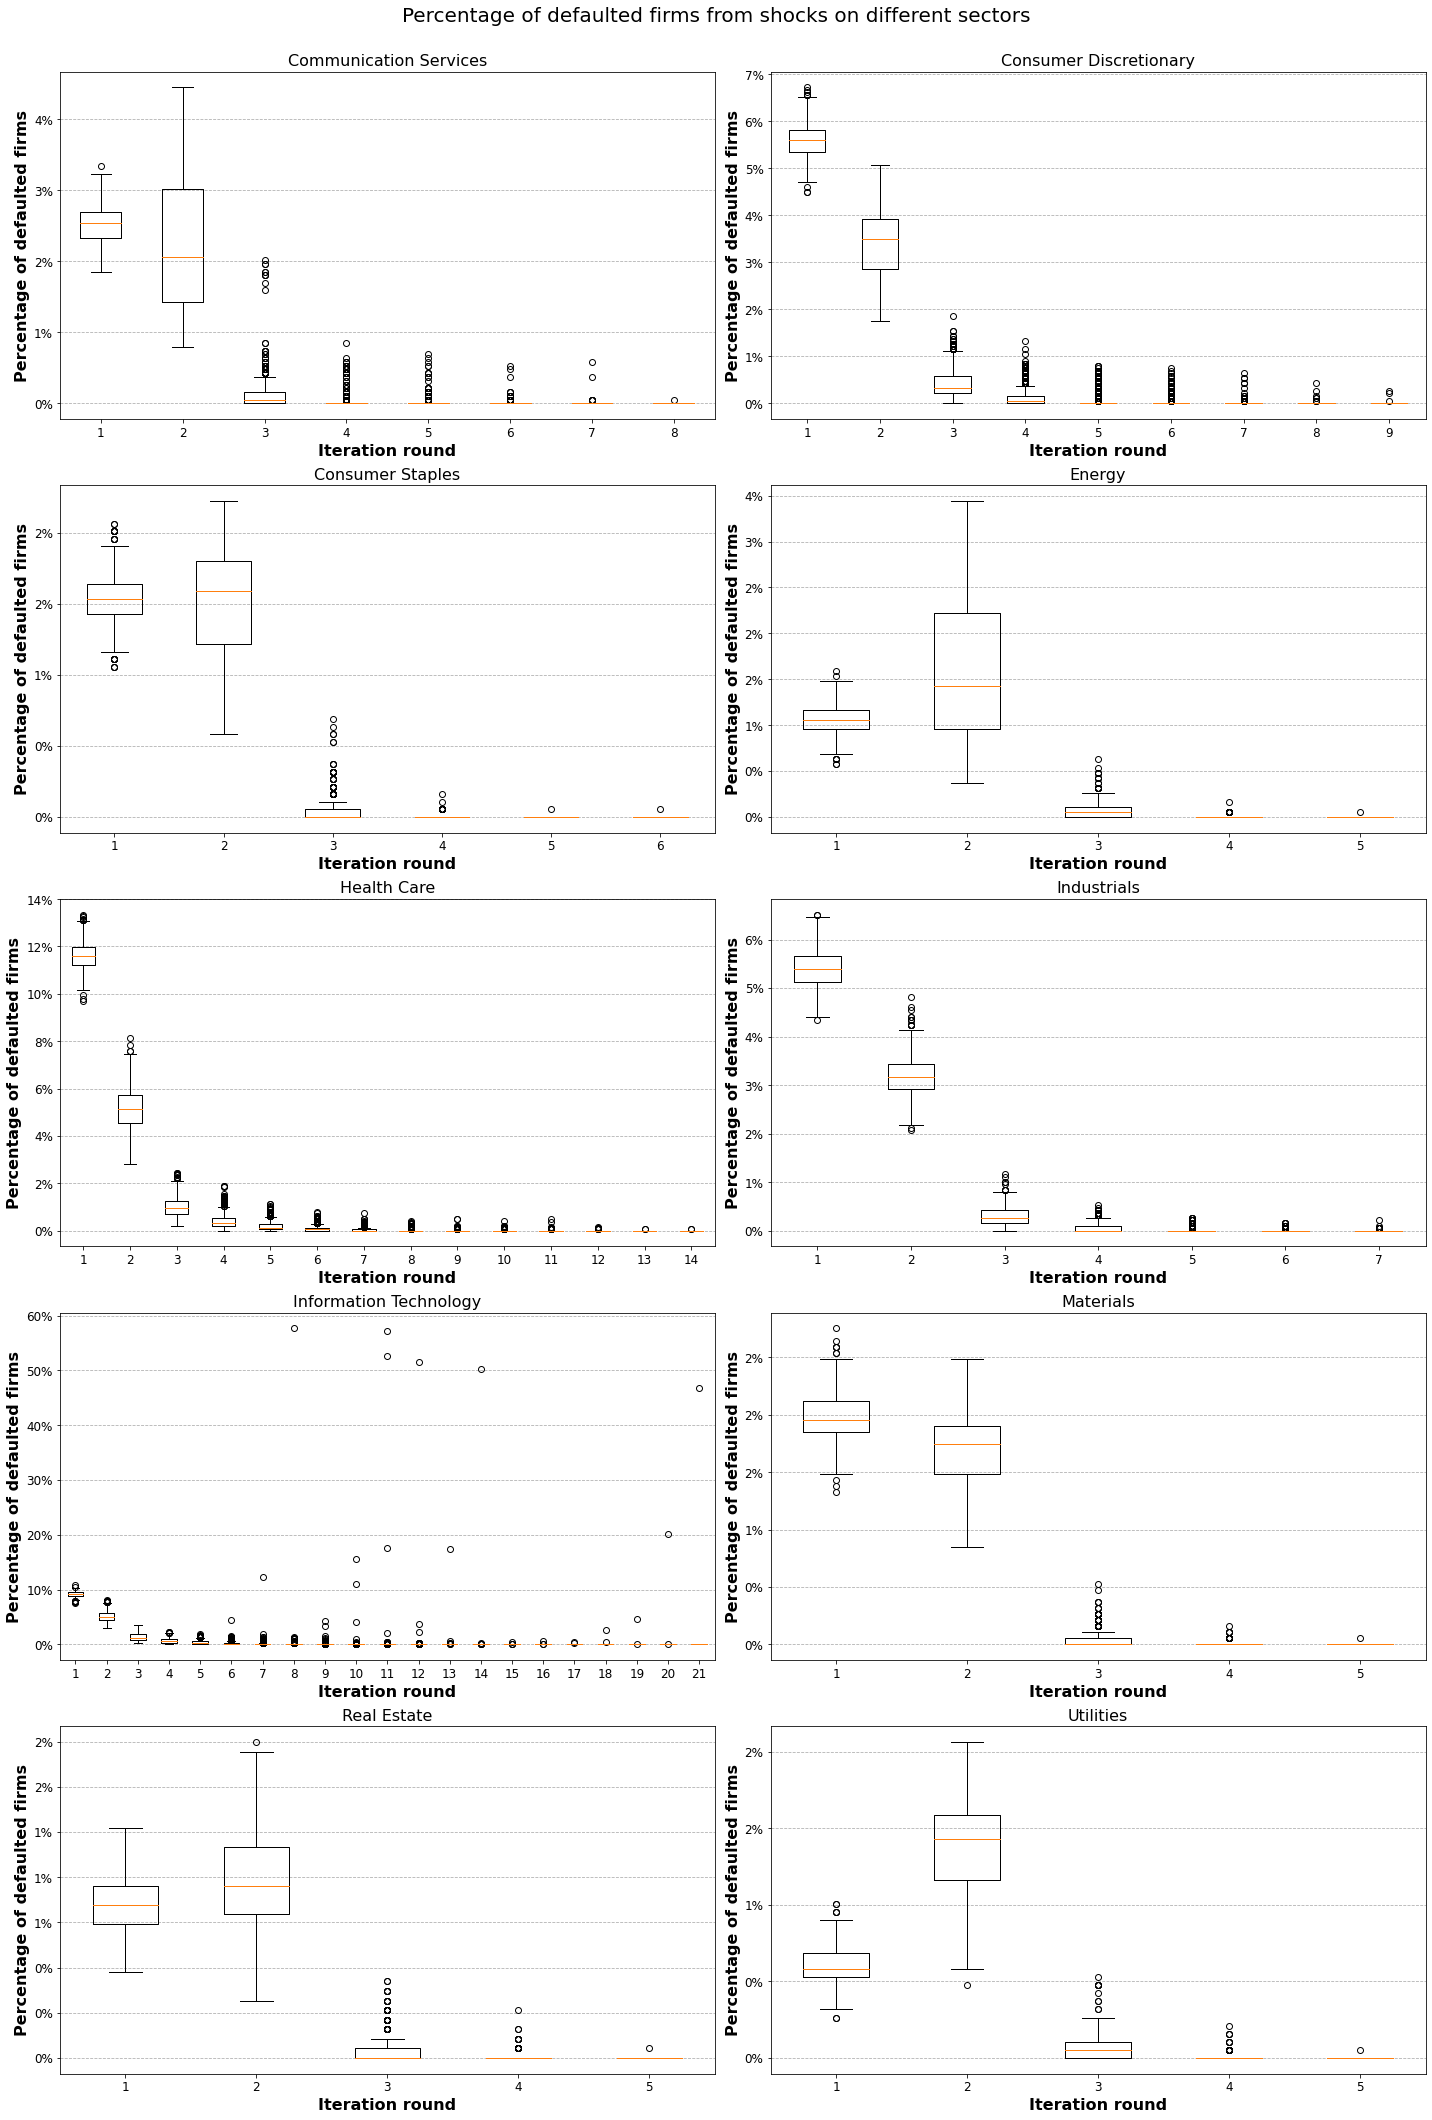

In [3]:
fig = plot_defaults(sectors_dict, "all", 'rounds')

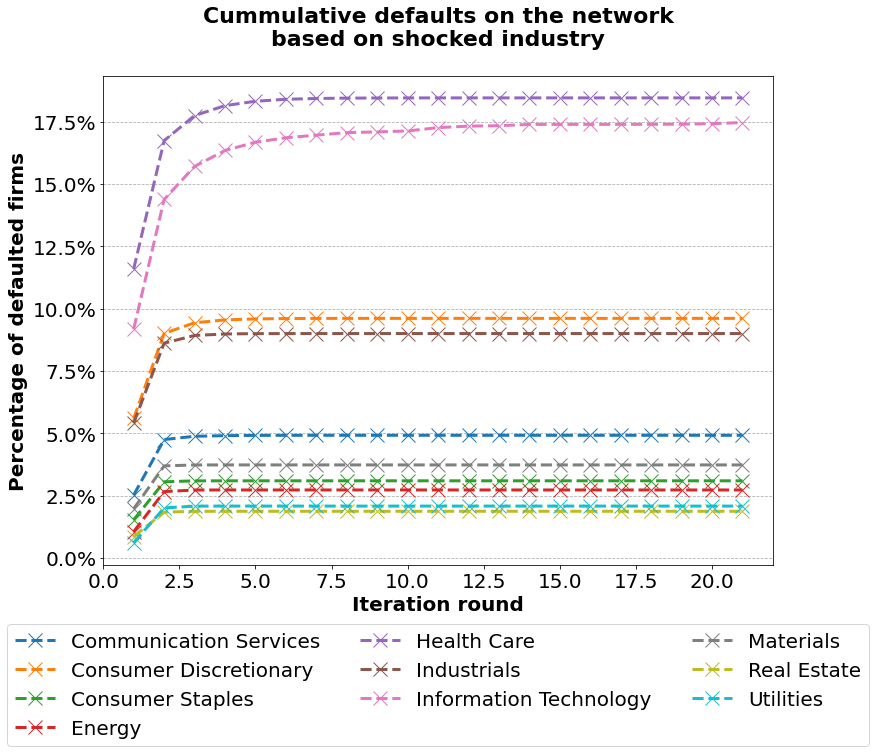

In [8]:
fig = plot_cummulative_defaults(sectors_dict)

In [ ]:
fig.savefig(f"{config_dict['outputs']['plots']}cummdef_lambda07_h03.png", bbox_inches='tight',dpi=600)

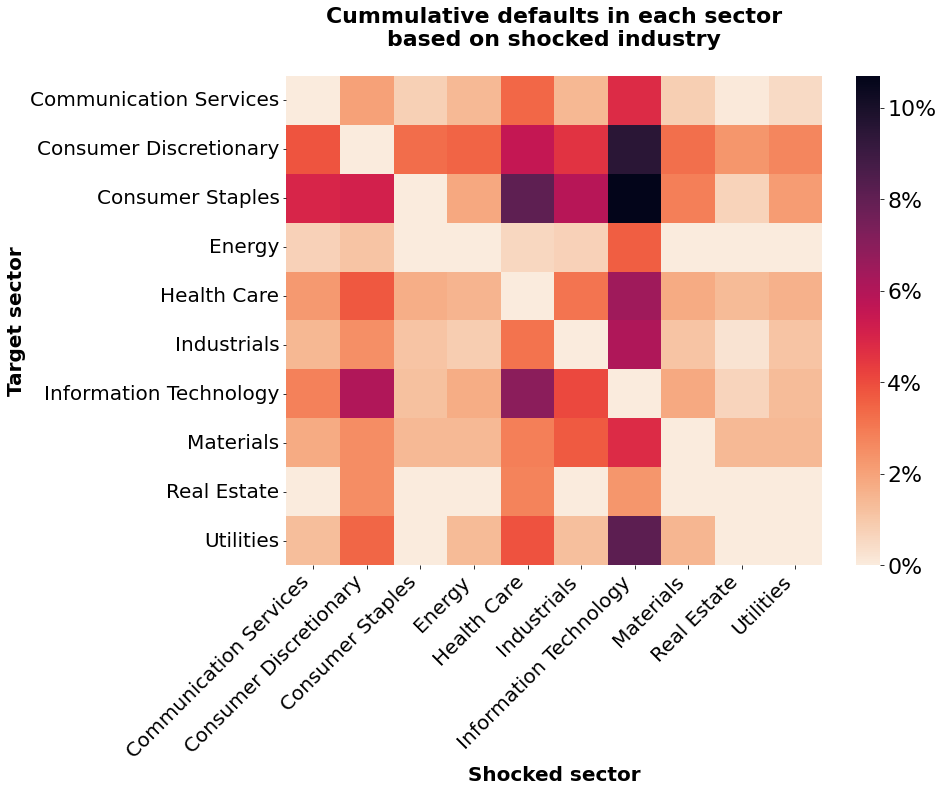

In [3]:
fig = plot_pairwise_effect(sectors_dict, include_self=False)

In [4]:
fig.savefig(f"{config_dict['outputs']['plots']}heatmap_lambda07_h03.png", bbox_inches='tight',dpi=600)

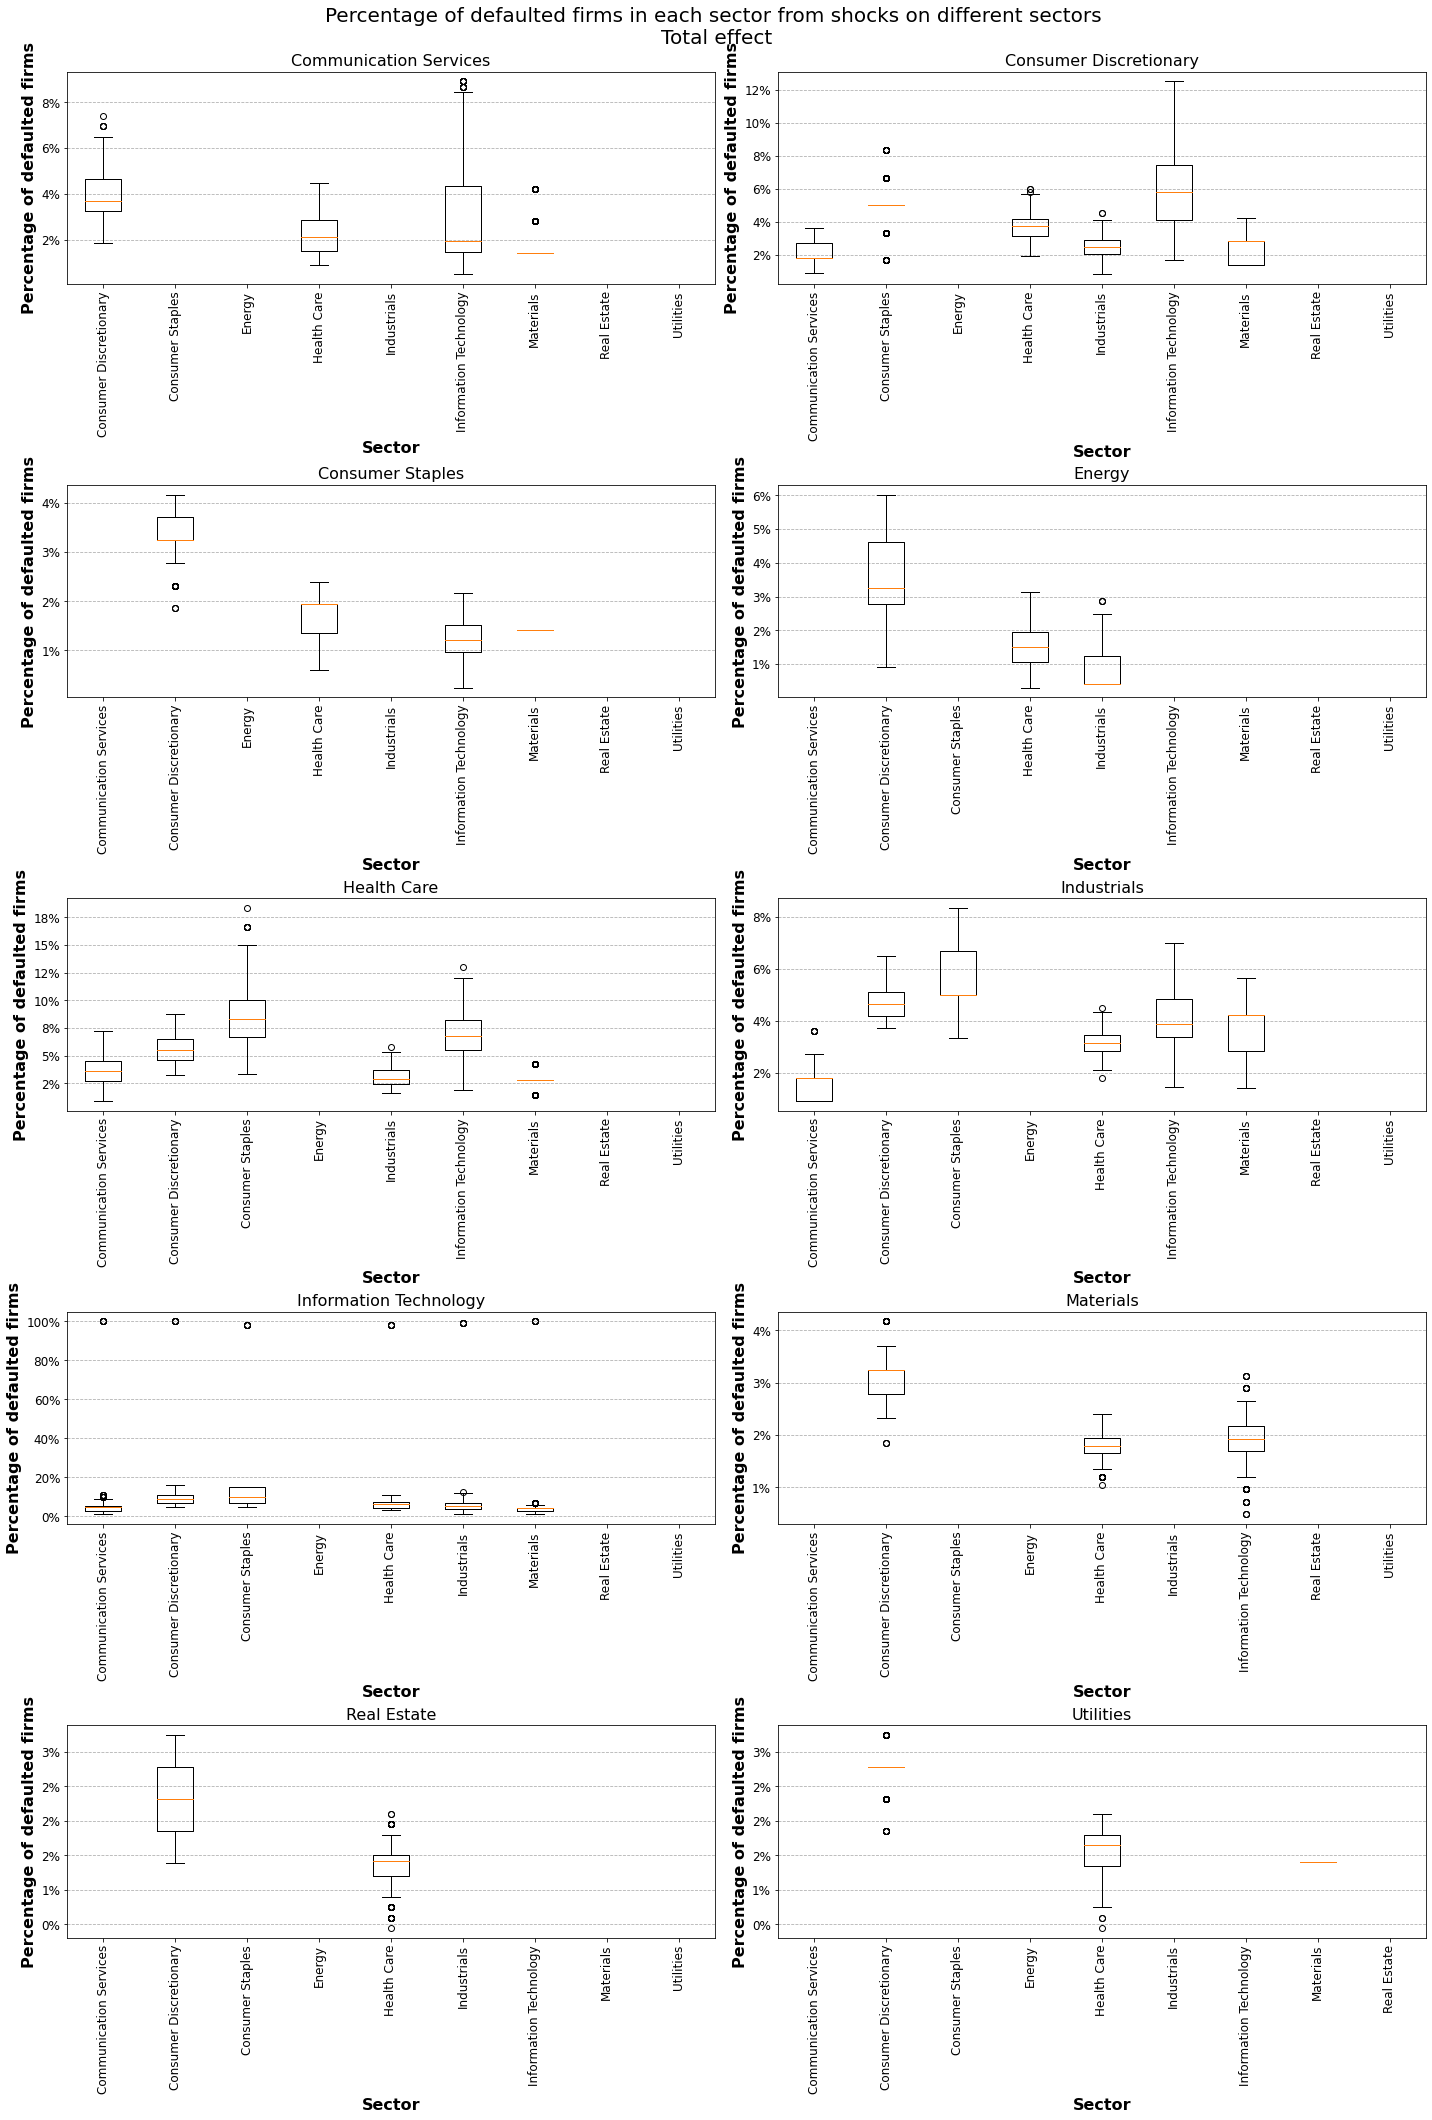

In [5]:
fig = plot_defaults(sectors_dict, "Information Technology", 'sectors_total')

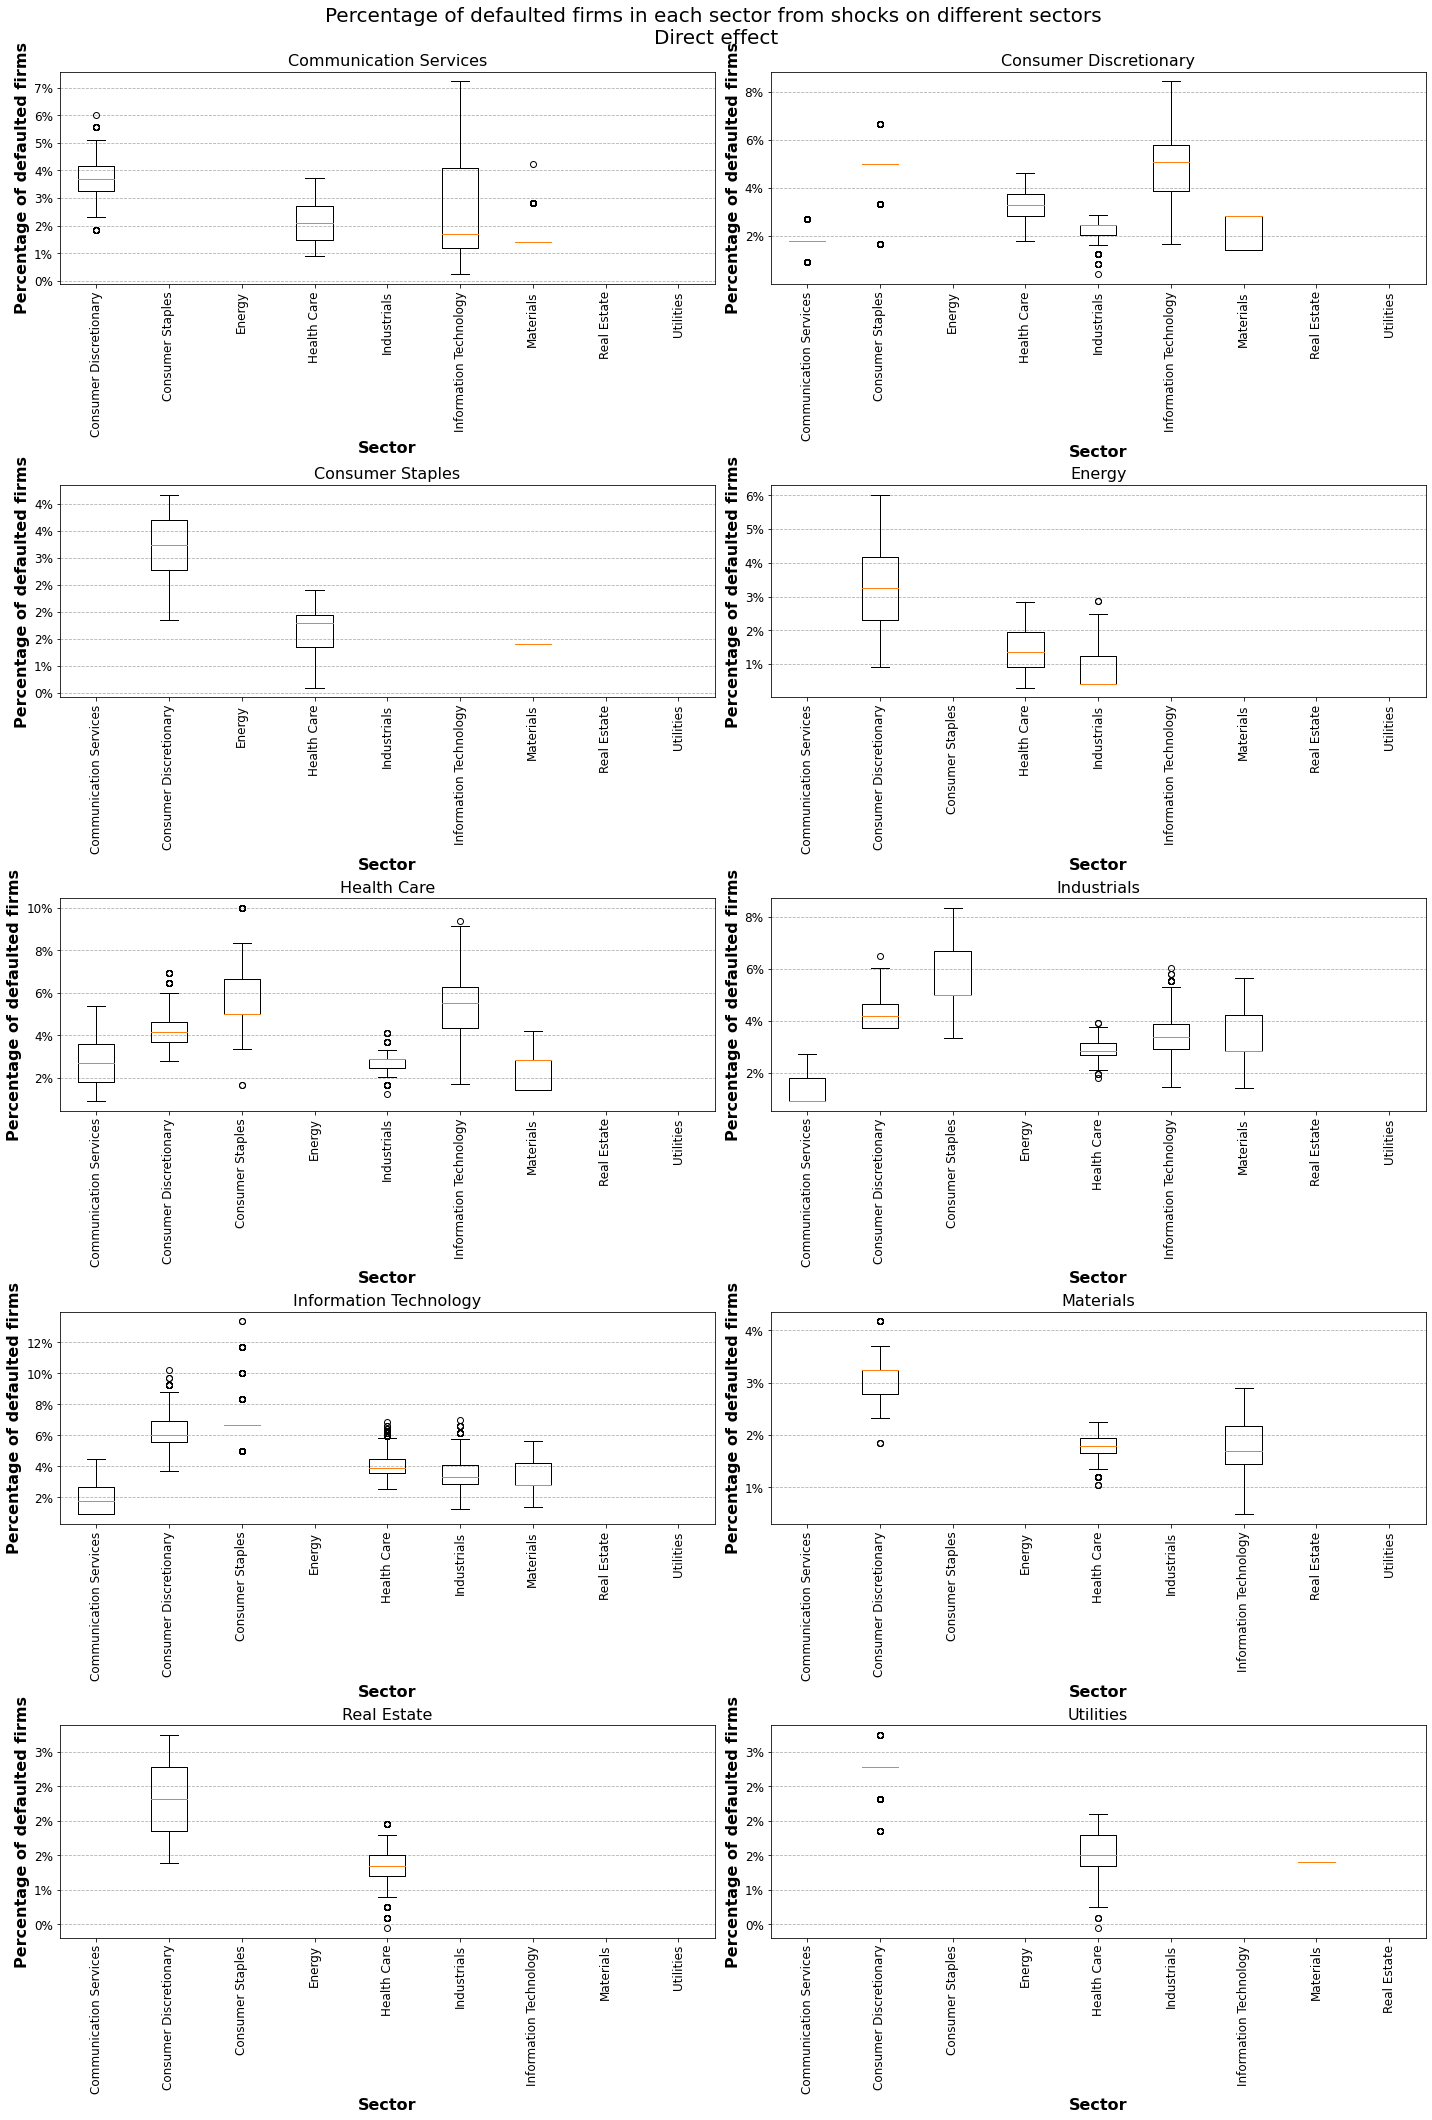

In [6]:
fig = plot_defaults(sectors_dict, "all", 'sectors_direct')

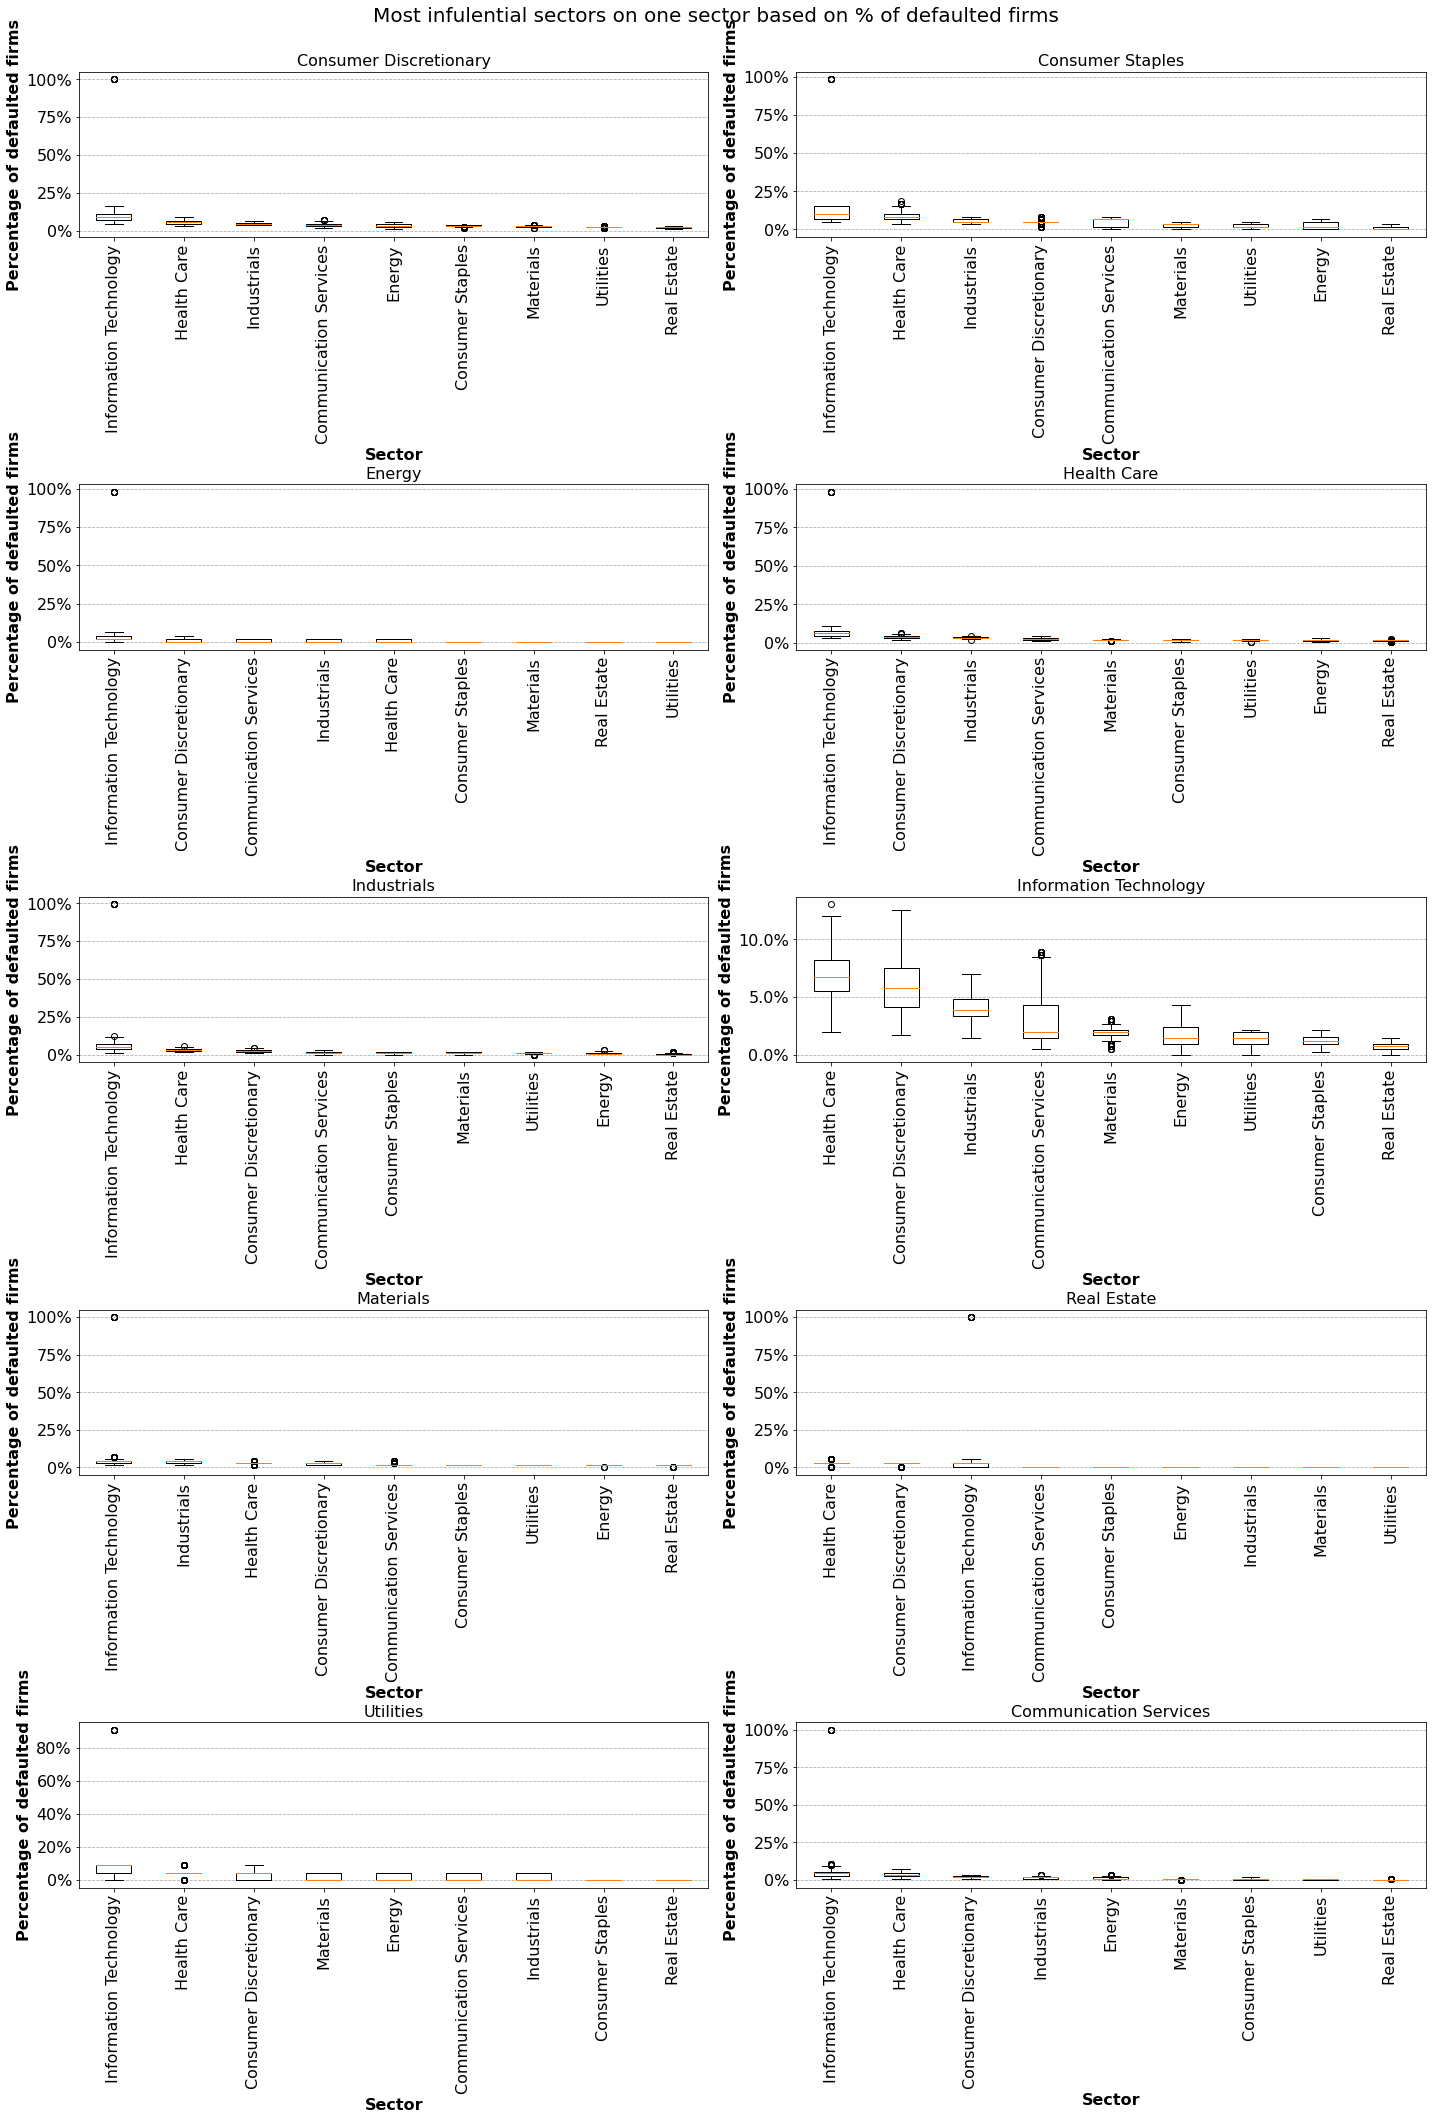

In [3]:
fig = plot_effect_on_sectors_from_other_sectors(sectors_dict)

In [6]:
df = sectors_dict["Utilities"][1]

In [8]:
df[df.sector == "Utilities"].groupby("default_round").count()

,ticker,sector,industry,assets,liabilities,equity,label,equity_orig
default_round,,,,,,,,
1.0,8,8,8,8,8,8,8,8


In [10]:
import pandas as pd


def count_defaults_each_round(df_list, sector, percent=False) -> pd.DataFrame:
    """
    Helper function that creates a dataframe with the defaulted firms in each round.
    The rows of the dictionary are the realizations while the columns represent
    each default round.
    """

    result_list = []
    for df in df_list:
        result_dict = {}
        res = df[~pd.isna(df.default_round) & (df.sector == sector)].groupby("default_round").count()["label"]
        for i in range(0, len(res)):

            result_dict[res.index[i]] = res.iloc[i]
        result_list.append(result_dict)

    result_df = pd.DataFrame.from_records(result_list).fillna(0)

    if percent:
        result_df = result_df / len(df_list[0]["label"]) * 100

    return result_df


def calculate_cummulative_defaults(sectors_dict):
    """
    Helper function that counts the cummulative defaults in each round for each
    shocked sector.
    """
    plot_dict = {}
    for (sec, df_list) in sectors_dict.items():

        defaulted_df = count_defaults_each_round(df_list)

        # calculating cummulative sum of defaults
        cumsum_df = defaulted_df.cumsum(axis=1)
        # expressing cummulative defaults as percentage of total nodes
        no_nodes = len(df_list[0]["label"])
        cumsum_df = cumsum_df / no_nodes * 100
        # calculating the mean of each cummulative sum value
        plot_dict[sec] = cumsum_df.mean(axis=0).to_dict()

    # calculating highest default round
    len_longest_list = len(max(plot_dict.values(), key=lambda x: len(x)))

    # adding zeros to rounds where there were no defaults to have all lists
    # with the same length
    for def_dict in plot_dict.values():

        for round in range(len(def_dict), len_longest_list):
            def_dict[round + 1] = def_dict[sorted(def_dict.keys())[-1]]

    return plot_dict



In [26]:
own = count_defaults_each_round(sectors_dict["Communication Services"], "Communication Services")

In [27]:
own.mean(axis='index')

1.0    47.665
2.0     1.848
3.0     0.199
5.0     0.012
4.0     0.042
6.0     0.008
7.0     0.001
dtype: float64

In [28]:
it = count_defaults_each_round(sectors_dict["Health Care"], "Communication Services")

In [29]:
it.mean(axis='index')

2.0     3.185
3.0     0.415
6.0     0.021
5.0     0.057
4.0     0.104
7.0     0.009
11.0    0.001
9.0     0.003
8.0     0.002
12.0    0.001
dtype: float64